!pip install minisom

In [1]:
import fitsio
from astropy.io import fits
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('som_sample.p', 'rb') as infile:
    som = pickle.load(infile)

In [3]:
kids_goldsample = fitsio.FITS('/net/home/fohlen13/yanza21/DATA/KiDS_data/KiDS_gold_smallsample.fits')

train_data = np.array(kids_goldsample[1]['MU_THRESHOLD',
                                         'FWHM_WORLD', 
                                         #'PSF_e1',
                                         #'PSF_e2', 
                                         'MAG_LIM_u', 
                                         'MAG_LIM_g',
                                         'MAG_LIM_r',
                                         'MAG_LIM_i',
                                         'MAG_LIM_Z',
                                         'MAG_LIM_Y',
                                         'MAG_LIM_J',
                                         'MAG_LIM_H',
                                         'MAG_LIM_Ks', 
                                         'EXTINCTION_r'][:].tolist())

train_data = train_data[np.where(~np.isnan(np.sum(train_data, axis=1)))[0]]
train_data = (train_data - np.mean(train_data, axis=0)) / np.std(train_data, axis=0)

In [5]:
train_data = np.array(kids_goldsample[1]['MU_THRESHOLD',
                                         'FWHM_WORLD', 
                                         'PSF_e1',
                                         'PSF_e2', 
                                         'MAG_LIM_u', 
                                         'MAG_LIM_g',
                                         'MAG_LIM_r',
                                         'MAG_LIM_i',
                                         'MAG_LIM_Z',
                                         'MAG_LIM_Y',
                                         'MAG_LIM_J',
                                         'MAG_LIM_H',
                                         'MAG_LIM_Ks', 
                                         'EXTINCTION_r'][:].tolist())
q = train_data.T[2] / train_data.T[3]
train_data.T[2] = 1-q
train_data = np.delete(train_data.T, 3, axis=0).T
invalid_ind = np.where(np.logical_or(np.abs(train_data)>100, np.isnan(train_data)))[0]

train_data = np.delete(train_data, invalid_ind, axis=0)
train_data = (train_data - np.mean(train_data, axis=0)) / np.std(train_data, axis=0)


/net/home/fohlen13/yanza21/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


som_dim = int((5*(train_data.shape[0])**0.5)**0.5)
som = MiniSom(som_dim, som_dim, train_data.shape[1], sigma=1, learning_rate=1, 
              neighborhood_function='gaussian', topology='hexagonal', random_seed=0) # initialization of 6x6 SOM
#som.random_weights_init(train_data)
som.pca_weights_init(train_data)
som.train(train_data, 5000000, random_order=True, verbose=True)

som.train(train_data, 100000, random_order=True, verbose=True)

In [7]:
from matplotlib.patches import RegularPolygon, Ellipse
from matplotlib import cm, colorbar

xx, yy = som.get_euclidean_coordinates()
umatrix = som.activation_response(train_data[:1000])
weights = som.get_weights()



In [8]:
from tqdm import tqdm
som_dim = som.distance_map().shape[0]
feature_map = np.zeros((som_dim, som_dim))
for i, data in tqdm(enumerate(train_data[:1000])):
    x,y = som.winner(data)
    feature_map[x,y] += data[0]

1000it [00:00, 5424.94it/s]


/net/home/fohlen13/yanza21/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


(-1.0, 59.75575286112626)

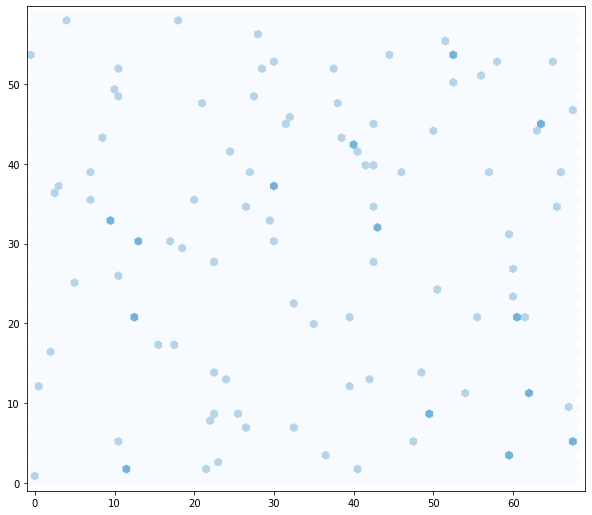

In [9]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=1 / np.sqrt(3),
                             facecolor=cm.Blues(np.log10(umatrix[i, j])), 
                             #alpha=.4, 
                             lw=0,
                             edgecolor='gray')
        ax.add_patch(hex)
ax.set_xlim(-1,som_dim)
ax.set_ylim(-1,som_dim * np.sqrt(3) / 2)


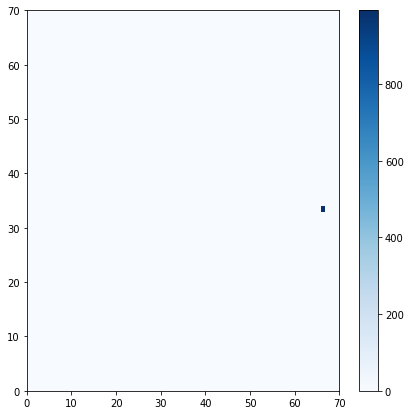

In [12]:
plt.figure(figsize=(7, 7))
frequencies = umatrix
plt.pcolor((frequencies.T), cmap='Blues') 
plt.colorbar()
plt.show()

In [13]:
frequencies

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

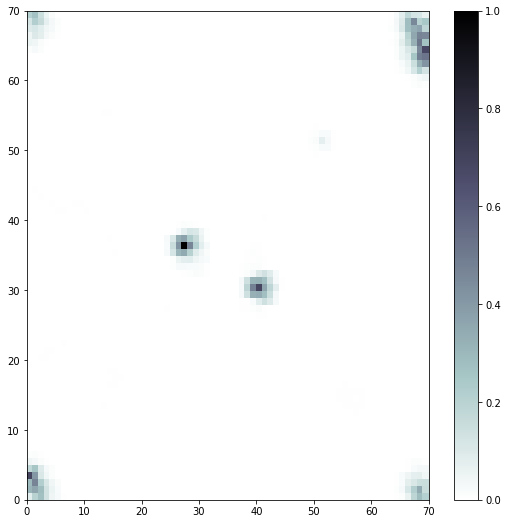

In [442]:
plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()